In [64]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [65]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Introduction 

Previous, I highlighted some basics notions in finance , how interpret and evaluate greeks when relevant informations is avaible on some derivatives.
I think finance is not a science instead of a life because It helps to price almost anything goods in the society and eases the trade around over the world.
In the context, I want to talk about the american option one of the interesting good in finance because it is sometimes difficult to modelize it when you fear the demonstration.
The idea of this notebook , it is to make easy some difficult thing on option.

# American Option

American option it is an option for which the owner have the right to start his option at any time between the starting date and the maturity.

Formally its price is given by the following optimal stopping time problem.
$$ P = \sup\limits_{\tau} \mathbb{E}[Z_{\tau}] $$
with $\tau$ as stopping time in $[0,T]$.

where $\tau$, describe all discrete stopping time at which the owner can exercise his right if he want when you assume the owner want to do lot of money.

This previous formula is fearsome and does not describe the strategy to make money easily. You can read the litterature to have a better demonstration of how the formula can be expressed with dynamic programming using a rationale reasoning.

In my concern, I explain  the formula to have a better understanding of strategy to make money with american option. 

The formula is designed as following :
$$ V_N = g(S_N) $$ 
$$ V_{k-1} = \sup \left\{ g(S_{k-1}) , \mathbb{E} \left[ V_{k} | \mathcal{F}_{k-1}  \right] \right\} $$
with $g$ a payoff function.


According the formula, when you know the payoff of the option, you're back at previous time before maturity, you evaluate your opportunity thanks this question, I exercise my right or not. If you think you make money at this time exercise else wait the maturity.
So you can apply this reasoning at anytime before the maturity to make money.

**NB** : For a call option, the best strategy is to wait for maturity and make money.

# Computation

In [66]:
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

Launching TensorBoard...

In [67]:
sys.path.append("/Users/mac/Downloads/OneDrive_1_23-04-2020/logs")

In [68]:
from amOp import *
import matplotlib.pyplot as plt
%matplotlib inline

verbose = True
preTrain = False
def priceAmericanBS(S_0, drift, implied_vol, maturity, Strike, regressor):
    #Simulate paths and initialize variables
    nbPaths = 10000
    nbCallDates = 36
    time_step = maturity / nbCallDates
    time_grid = generate_time_grid(time_step, T)
    
    #Generate paths
    paths = simulate(time_grid, time_step, nbPaths, drift, implied_vol, S_0)
    
    #Compute discount factors between two exercise dates
    stepDiscountingFactor = np.exp(-drift * time_step)
    
    #Initialize option value grid and compute Payoff for terminal date 
    continuationValueGrid = np.zeros_like(paths)
    continuationValueGrid[:,-1] = np.maximum(paths[:,-1] - Strike,0)
    tau = np.ones_like(continuationValueGrid[:,-1]) * (-1)
    
    priceRes = None
    #Iterate backward on dates
    figAdd = []
    for k in np.arange(len(time_grid)-1)[::-1]:
        #Determine the payoff for exercise date k
        payoff = np.maximum(paths[:,k] - Strike,0)

        if k > 0 :
          #determine in the money paths
          hasPositivePayoff = payoff > 0 
          #Compute discounted V_{k + 1} paths
          Y = stepDiscountingFactor * continuationValueGrid[:,k+1]
          #Get underlying paths at time k
          x = paths[:,k]

          if verbose :
            conditionalExpectation = polynomialRegressor(Y[hasPositivePayoff],
                                                         x[hasPositivePayoff],
                                                         x,
                                                         preTrained=(k<len(time_grid)-2))
            plt.plot(pd.Series(Y,index=x).sort_index(),label="Ref")
            plt.plot(pd.Series(conditionalExpectation,index=x).sort_index(),label="Polynomial")

          conditionalExpectation = regressor(Y[hasPositivePayoff],
                                             x[hasPositivePayoff],
                                             x,
                                             preTrained=(k<len(time_grid)-2))
          if verbose :
            plt.plot(pd.Series(conditionalExpectation,index=x).sort_index(),label="Neural")
            plt.legend()
            plt.show()

          
          #Decide on which paths the option is exercised
          isCalled = (payoff >= conditionalExpectation) * hasPositivePayoff
          
          continuationValueGrid[:,k] = np.where(isCalled, 
                                                payoff, 
                                                stepDiscountingFactor * continuationValueGrid[:,k+1])

          tau[isCalled] = k
        else :
          #Final Monte Carlo check if american option is not degenerate
          priceRes = max(np.mean(continuationValueGrid[:,1] * stepDiscountingFactor), payoff[0])
          variance = np.var(continuationValueGrid[:,1] * stepDiscountingFactor)
          print("American call Price : ",priceRes)
          print("Variance : ",variance)
          print("European call Price : ",np.mean(continuationValueGrid[:,-1]) * np.exp(-drift * maturity))
          
    return priceRes

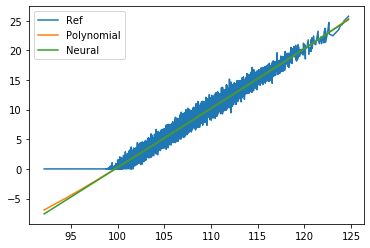

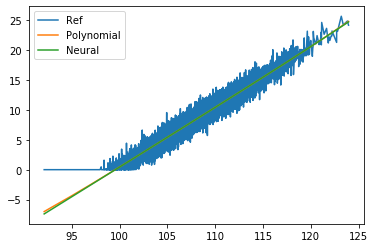

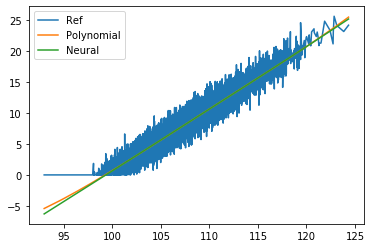

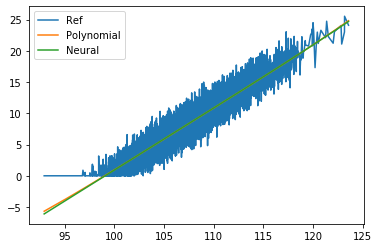

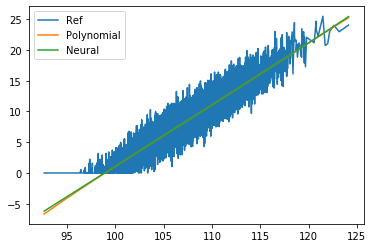

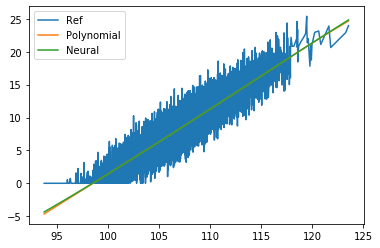

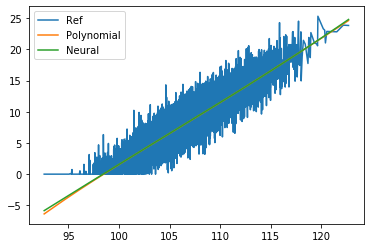

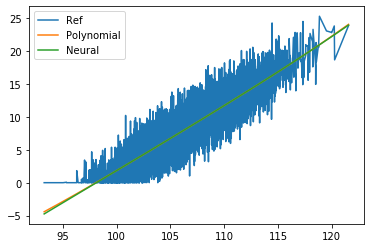

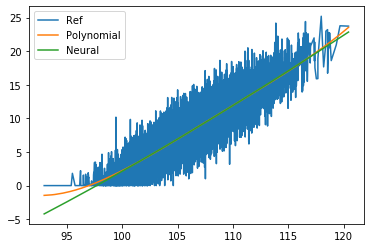

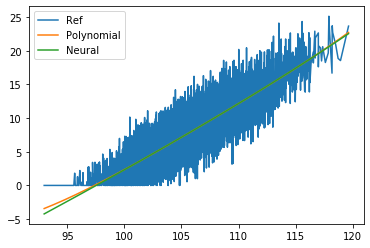

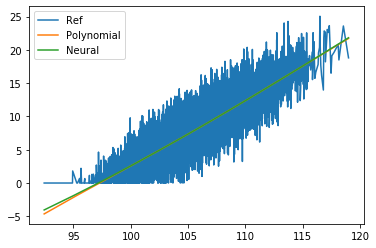

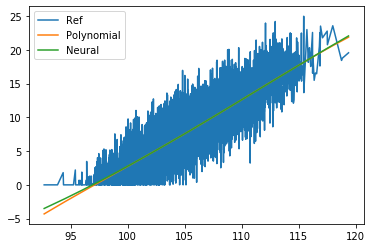

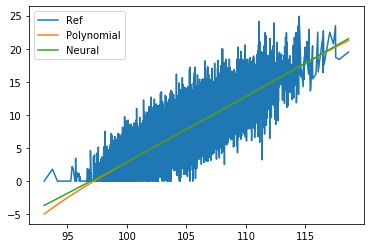

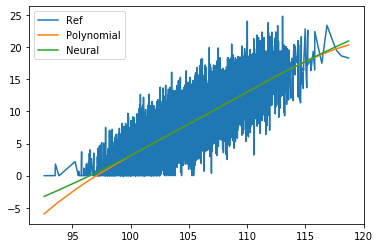

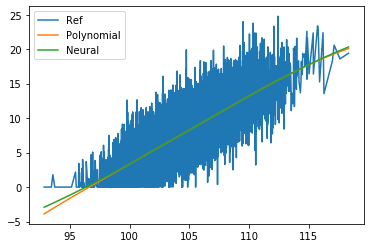

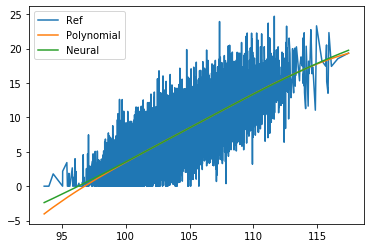

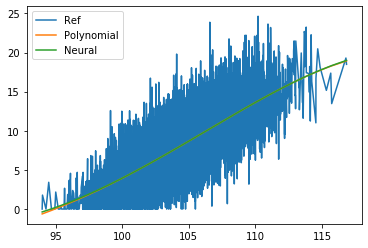

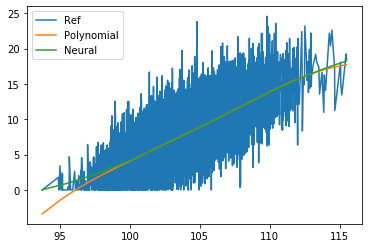

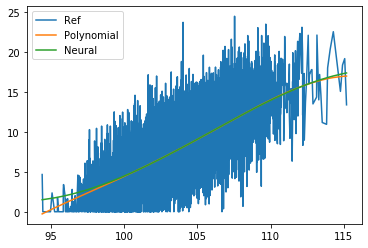

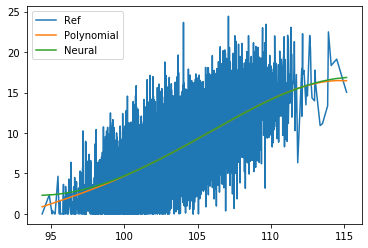

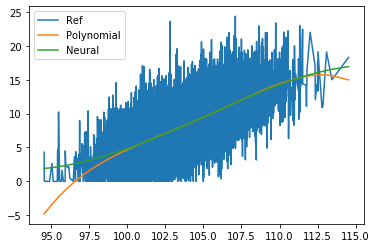

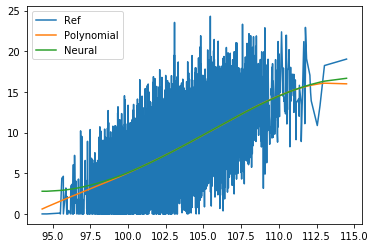

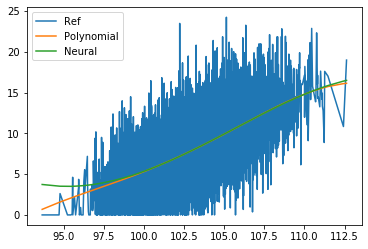

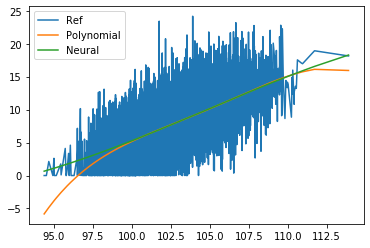

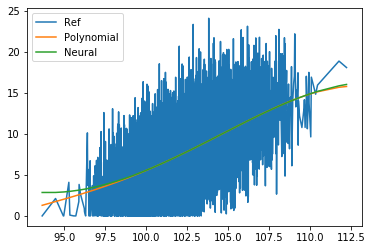

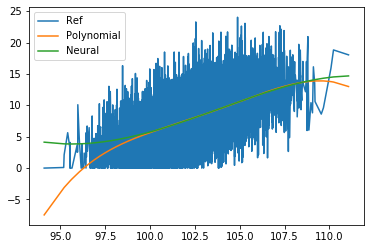

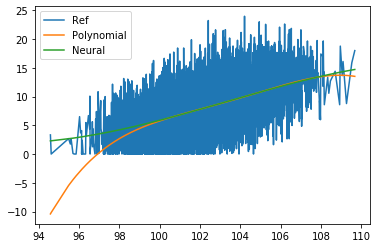

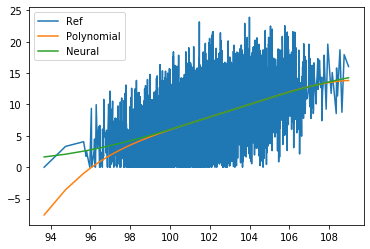

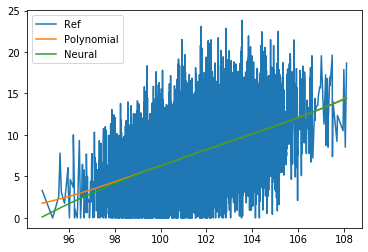

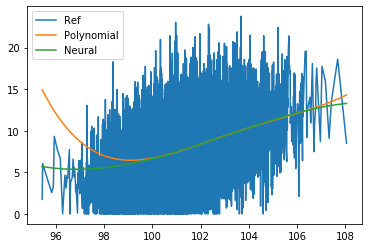

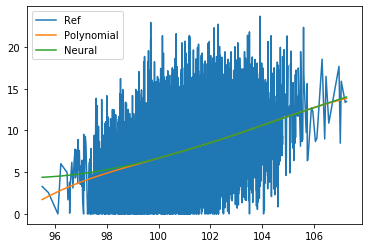

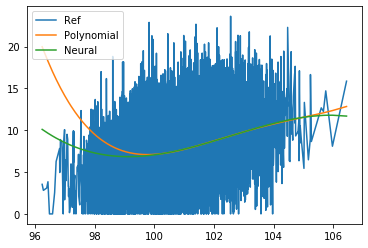

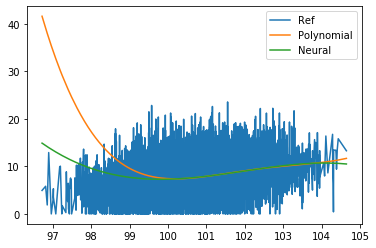

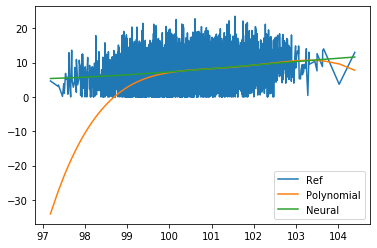

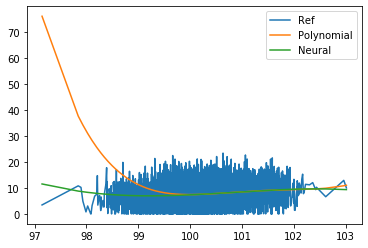

American call Price :  7.656870833830576
Variance :  14.942098499027619
European call Price :  7.656870833830588


In [69]:
T = 1.0; b = 0.1; sigma=0.2; S0 = 100
nbPaths = 10000

p = priceAmericanBS(S0, b, sigma, T, 100, linearRegressor)